# Analysing data of the telecom operator
## determine profitability of two prepaid plans

This study aims to study the behavior of subscribers of a given telecom operator. Compare the behavior of subscribers connected to different plans. Explore if there are certain patterns? Track how the behavior changes from month to month. And most importantly, to find out which plan is most profitable for a mobile operator? Which tariff plan brings more profit and puts less load on the network.

### analysis plan:
1. describe data in general
2. fix data
    * NA 
    * outliers
    * anomalies
3. prepare data
    * create supporting variables
4. analyze clients' behavior
    * explore some correlations
    * build plots
    * find measures of average and variance
6. test hypotheses
    * find the average profit difference of two plans
    * find the average profit difference from the users form two regions
7. and determine which prepaid plan is more profitable

## Describe data

In [1]:
import pandas as pd
import numpy as np
import os
import math
from scipy import stats as st
import matplotlib.pyplot as plt

#import plotly.graph_objects as go
from plotly import graph_objects as go

from matplotlib import pyplot
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
## reviewer's code

cd = os.getcwd()

df_calls = pd.read_csv(cd + '/datasets/Megaline/megaline_calls.csv')
df_internet = pd.read_csv(cd + '/datasets/Megaline/megaline_internet.csv')
df_messages = pd.read_csv(cd + '/datasets/Megaline/megaline_messages.csv')
df_plans = pd.read_csv(cd + '/datasets/Megaline/megaline_plans.csv')
df_users = pd.read_csv(cd + '/datasets/Megaline/megaline_users1.csv')

data = [df_calls, df_internet, df_messages, df_plans, df_users]
print(data)

[              id  user_id   call_date  duration
0        1000_93     1000  2018-12-27      8.52
1       1000_145     1000  2018-12-27     13.66
2       1000_247     1000  2018-12-27     14.48
3       1000_309     1000  2018-12-28      5.76
4       1000_380     1000  2018-12-30      4.22
...          ...      ...         ...       ...
137730  1499_199     1499  2018-11-21      8.72
137731  1499_200     1499  2018-10-20     10.89
137732  1499_201     1499  2018-09-21      8.12
137733  1499_202     1499  2018-10-10      0.37
137734  1499_203     1499  2018-12-29     13.86

[137735 rows x 4 columns],               id  user_id session_date  mb_used
0        1000_13     1000   2018-12-29    89.86
1       1000_204     1000   2018-12-31     0.00
2       1000_379     1000   2018-12-28   660.40
3       1000_413     1000   2018-12-26   270.99
4       1000_442     1000   2018-12-27   880.22
...          ...      ...          ...      ...
104820  1499_215     1499   2018-10-20   218.06
104821  149

In [5]:
def descr_data_list(data):
    n = 0
    for df in data:
        n += 1
        print('Data', n)
        print('head')
        print(df.head())
        print()
        print('info')
        print(df.info())
        print()
        print('isna')
        print(df.isna().sum().sort_values(ascending=False))
        print()
        print('describe')
        print(df.describe())
        print()
        print()
        
descr_data_list(data)

Data 1
head
         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

isna
duration     0
call_date    0
user_id      0
id           0
dtype: int64

describe
             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290

In [6]:
df_users['city'].sort_values().unique()
df_users['plan'].value_counts()

surf        339
ultimate    161
Name: plan, dtype: int64

As we can see, data need some fixes: change format of date and fill na for var *'churn_date'* in *df_users*.

## Fix data

In [7]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

df_users['churn_date'][df_users['churn_date'].isna()] = df_calls['call_date'].max()

In [8]:
last_call = df_calls.groupby('user_id')['call_date'].max().reset_index() 
df_users_lastcall = df_users.merge(last_call, how='left', on='user_id')
print(len(df_users_lastcall[df_users_lastcall['churn_date']<df_users_lastcall['call_date']]), 'rows - abnormal data. Calls were made after the user left.')

30 rows - abnormal data. Calls were made after the user left.


## Prepare data

[]

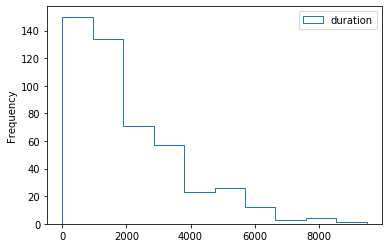

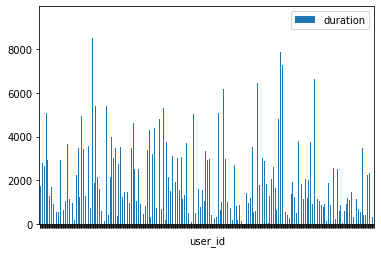

In [9]:
#calls by month

calls_month = df_calls
calls_month['duration'] = np.ceil(calls_month['duration'])
calls_month['duration'] = calls_month['duration'].astype('int')
calls_month['month'] = calls_month['call_date'].values.astype('datetime64[M]')
calls_user_month = calls_month.groupby(['user_id', 'month'])['duration'].agg('sum').reset_index()

(calls_month
    .groupby(['user_id'])['duration']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='duration',kind='hist',histtype='step'))
(calls_month
    .groupby(['user_id'])['duration']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='duration',kind='bar')
    .set_xticklabels([]))

[]

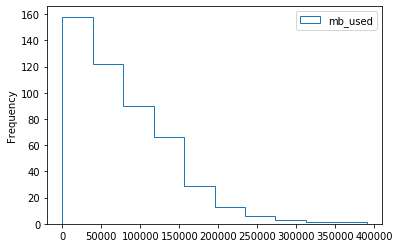

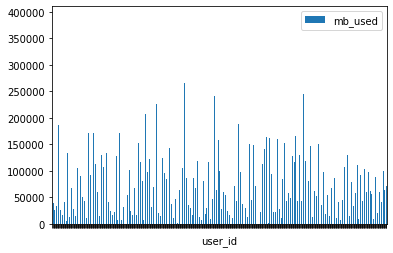

In [10]:
#ineternet by month

internet_month = df_internet
internet_month['mb_used'] = np.ceil(internet_month['mb_used'])
internet_month['mb_used'] = internet_month['mb_used'].astype('int')
internet_month['month'] = internet_month['session_date'].values.astype('datetime64[M]')
internet_user_month = internet_month.groupby(['user_id','month'])['mb_used'].agg('sum').reset_index()

(internet_month
    .groupby(['user_id'])['mb_used']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='mb_used',kind='hist',histtype='step'))
(internet_month
    .groupby(['user_id'])['mb_used']
    .agg('sum')
    .reset_index()
    .plot(x='user_id',y='mb_used',kind='bar')
    .set_xticklabels([]))

[]

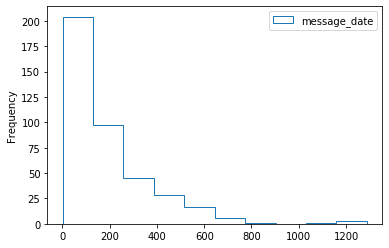

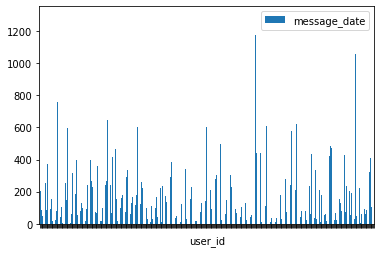

In [11]:
#messeges by month

messages_month = df_messages
messages_month['month'] = messages_month['message_date'].values.astype('datetime64[M]')
messages_user_month = messages_month.groupby(['user_id','month'])['message_date'].agg('count').reset_index()

(messages_month
    .groupby(['user_id'])['message_date']
    .agg('count')
    .reset_index()
    .plot(x='user_id',y='message_date',kind='hist',histtype='step'))
(messages_month
    .groupby(['user_id'])['message_date']
    .agg('count')
    .reset_index()
    .plot(x='user_id',y='message_date',kind='bar')
    .set_xticklabels([]))

Here I prepared three tables with data by minutes, messages and traffic, for their subsequent joining with the main table of the report. To do this, I grouped the data by user and month. Pre-creating a column with months.

In [12]:
min_month = df_calls['call_date'].values.astype('datetime64[M]').min()-1
max_month = df_calls['call_date'].values.astype('datetime64[M]').max()
dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
dr.columns = ['month']
dr['key'] = 1

df_users['key'] = 1
users_report = dr.merge(df_users,on='key')

users_report['reg_month'] = users_report['reg_date'].values.astype('datetime64[M]')
users_report['churn_month'] = users_report['churn_date'].values.astype('datetime64[M]')

users_report = users_report[users_report['month'] >= users_report['reg_month']]
users_report = users_report[users_report['month'] <= users_report['churn_month']]

users_report = users_report.groupby(['user_id', 'month'])['plan','city'].min().reset_index()

report = users_report.merge(calls_user_month,how='left',on=['user_id','month'])
report = report.merge(internet_user_month,how='left',on=['user_id','month'])
report = report.merge(messages_user_month,how='left',on=['user_id','month'])

# report['duration'] = report['duration'].fillna(value=0)
# report['mb_used'] = report['mb_used'].fillna(value=0)
# report['message_date'] = report['message_date'].fillna(value=0)

# report[report['user_id']==1191]
# report[report['user_id']==1008]

# df_calls[df_calls['user_id']==1002].groupby('month')['duration'].agg('sum').reset_index()
# calls_user_month[calls_user_month['user_id']==1002]
# internet_user_month[internet_user_month['user_id']==1002]

In [13]:
report

,user_id,month,plan,city,duration,mb_used,message_date
0,1000,2018-12-01,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",124.0,1903.0,11.0
1,1001,2018-08-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",182.0,6929.0,30.0
2,1001,2018-09-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",315.0,13333.0,44.0
3,1001,2018-10-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",393.0,22356.0,53.0
4,1001,2018-11-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",426.0,18524.0,36.0
...,...,...,...,...,...,...,...
3308,1499,2018-08-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",NaN,NaN,NaN
3309,1499,2018-09-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",346.0,13004.0,NaN
3310,1499,2018-10-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",385.0,19515.0,NaN
3311,1499,2018-11-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",308.0,16834.0,NaN


In [14]:
report.columns = ['user_id', 'month', 'plan', 'city', 'minutes_used', 'mb_used', 'message_used']
report

,user_id,month,plan,city,minutes_used,mb_used,message_used
0,1000,2018-12-01,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",124.0,1903.0,11.0
1,1001,2018-08-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",182.0,6929.0,30.0
2,1001,2018-09-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",315.0,13333.0,44.0
3,1001,2018-10-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",393.0,22356.0,53.0
4,1001,2018-11-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",426.0,18524.0,36.0
...,...,...,...,...,...,...,...
3308,1499,2018-08-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",NaN,NaN,NaN
3309,1499,2018-09-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",346.0,13004.0,NaN
3310,1499,2018-10-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",385.0,19515.0,NaN
3311,1499,2018-11-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",308.0,16834.0,NaN


A table with user data was multiplied by a table with a range of months. Further, months before and Metz were excluded after connecting to the tariff plan. And finally, I combined all four tables into one big report table.

# Final Report table

In [15]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [16]:
for index in range(len(report)):
    user = report.loc[index]

    if 'surf' in str(user['plan']):
        #pay for minutes per month
        over_min = user['minutes_used'] - df_plans.loc[0]['minutes_included']
        if over_min > 0:
            over_pay_min = over_min * df_plans.loc[0]['usd_per_minute']
        else:
            over_pay_min = 0
        #pay for mb(internet) per month    
        over_mb = user['mb_used'] - df_plans.loc[0]['mb_per_month_included']
        if over_mb > 0:
            over_pay_mb = math.ceil(over_mb/1000) * df_plans.loc[0]['usd_per_gb']
        else:
            over_pay_mb = 0
        #pay for messages per month    
        over_mess = user['message_used'] - df_plans.loc[0]['messages_included']
        if over_mess > 0:
            over_pay_mess = over_mess * df_plans.loc[0]['usd_per_message']
        else:
            over_pay_mess = 0
        #total pay per month
        total_per_month = df_plans.loc[0]['usd_monthly_pay'] + over_pay_min + over_pay_mb + over_pay_mess
        report.loc[index,'revenue'] = total_per_month

    else:
        #pay for minutes per month
        over_min = user['minutes_used'] - df_plans.loc[1]['minutes_included']
        if over_min > 0:
            over_pay_min = over_min * df_plans.loc[1]['usd_per_minute']
        else:
            over_pay_min = 0
        #pay for mb(internet) per month    
        over_mb = user['mb_used'] - df_plans.loc[1]['mb_per_month_included']
        if over_mb > 0:
            over_pay_mb = math.ceil(over_mb/1000) * df_plans.loc[1]['usd_per_gb']
        else:
            over_pay_mb = 0
        #pay for messages per month    
        over_mess = user['message_used'] - df_plans.loc[1]['messages_included']
        if over_mess > 0:
            over_pay_mess = over_mess * df_plans.loc[1]['usd_per_message']
        else:
            over_pay_mess = 0
        #total pay per month
        total_per_month = df_plans.loc[1]['usd_monthly_pay'] + over_pay_min + over_pay_mb + over_pay_mess
        report.loc[index,'revenue'] = total_per_month

report

,user_id,month,plan,city,minutes_used,mb_used,message_used,revenue
0,1000,2018-12-01,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",124.0,1903.0,11.0,70.00
1,1001,2018-08-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",182.0,6929.0,30.0,20.00
2,1001,2018-09-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",315.0,13333.0,44.0,20.00
3,1001,2018-10-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",393.0,22356.0,53.0,90.09
4,1001,2018-11-01,surf,"Seattle-Tacoma-Bellevue, WA MSA",426.0,18524.0,36.0,60.00
...,...,...,...,...,...,...,...,...
3308,1499,2018-08-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",NaN,NaN,NaN,20.00
3309,1499,2018-09-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",346.0,13004.0,NaN,20.00
3310,1499,2018-10-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",385.0,19515.0,NaN,70.00
3311,1499,2018-11-01,surf,"Orlando-Kissimmee-Sanford, FL MSA",308.0,16834.0,NaN,40.00


I wrote a condition according to which each variable for each user for each month was checked for exceeding tariff limits, pre-sorting according to two plans. As a result, a new column was created with revenue for each month for each user.

## Check report table

in report controll sum is less because there is an anomaly in the data. there are users who allegedly made calls after the service was disconnected. I ruled out these calls as anomalies.

In [17]:
df_calls[df_calls['user_id']==1191]['duration'].sum()

3746

In [18]:
report[report['user_id']==1191]['minutes_used'].sum()

3121.0

with other users, everything is fine

In [19]:
report[report['user_id']==1002]['minutes_used'].sum()

829.0

In [20]:
report[report['user_id']==1002]['minutes_used'].sum()

829.0

In [21]:
len(report[report['revenue']!=20][report['revenue']!=70])

1132

### From month to month, total revenue increased

In [22]:
report.groupby('month')['revenue'].agg('sum').reset_index()

,month,revenue
0,2018-01-01,1930.00
1,2018-02-01,3509.57
2,2018-03-01,5342.65
3,2018-04-01,7255.53
4,2018-05-01,9728.37
5,2018-06-01,12656.80
6,2018-07-01,16442.56
7,2018-08-01,20256.85
8,2018-09-01,21619.67
9,2018-10-01,26083.02


### Preliminary comparison

In [23]:
plans_revenue = report.groupby('plan')['revenue'].agg('sum').reset_index()
plans_revenue.loc[0, 'revenue_per_user'] = plans_revenue.loc[0, 'revenue'] / len(report[report['plan']=='surf'])
plans_revenue.loc[1, 'revenue_per_user'] = plans_revenue.loc[1, 'revenue'] / len(report[report['plan']=='ultimate'])

In [24]:
plans_revenue

,plan,revenue,revenue_per_user
0,surf,109067.67,48.647489
1,ultimate,76692.00,71.607843


In [25]:
plans_revenue.loc[1, 'revenue_per_user'] - plans_revenue.loc[0, 'revenue_per_user']

22.96035428801322

In [26]:
len(report[report['plan']=='surf']) / len(report[report['plan']=='ultimate'])

2.093370681605976

In [27]:
plans_revenue.loc[0,'revenue'] / plans_revenue.loc[1,'revenue']

1.4221518541699245

In [28]:
report[report['plan']=='surf'][report['revenue']==20].sum()

user_id                                                   1392857
plan            surfsurfsurfsurfsurfsurfsurfsurfsurfsurfsurfsu...
city            Seattle-Tacoma-Bellevue, WA MSASeattle-Tacoma-...
minutes_used                                               100177
mb_used                                               3.68533e+06
message_used                                                 6004
revenue                                                     22320
dtype: object

In [29]:
len(report[report['plan']=='surf'][report['revenue']>20]) / len(report[report['plan']=='surf'])

0.5022301516503123

In [30]:
len(report[report['plan']=='ultimate'][report['revenue']>70]) / len(report[report['plan']=='ultimate'])

0.03828197945845005

Users of the surf plan are twice as many, and brougth 42% more profit then users on utimate plan. 
But despite this, the ultimate plan brought 23 dollars more profit per user.
Also interesting fact that, half of the users inside 'surf' plan overpaid, on the other hand users of 'ultimate' plan mostly stay inside the limits.

### Сorr matrix. Users behavior

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B8933D0548>


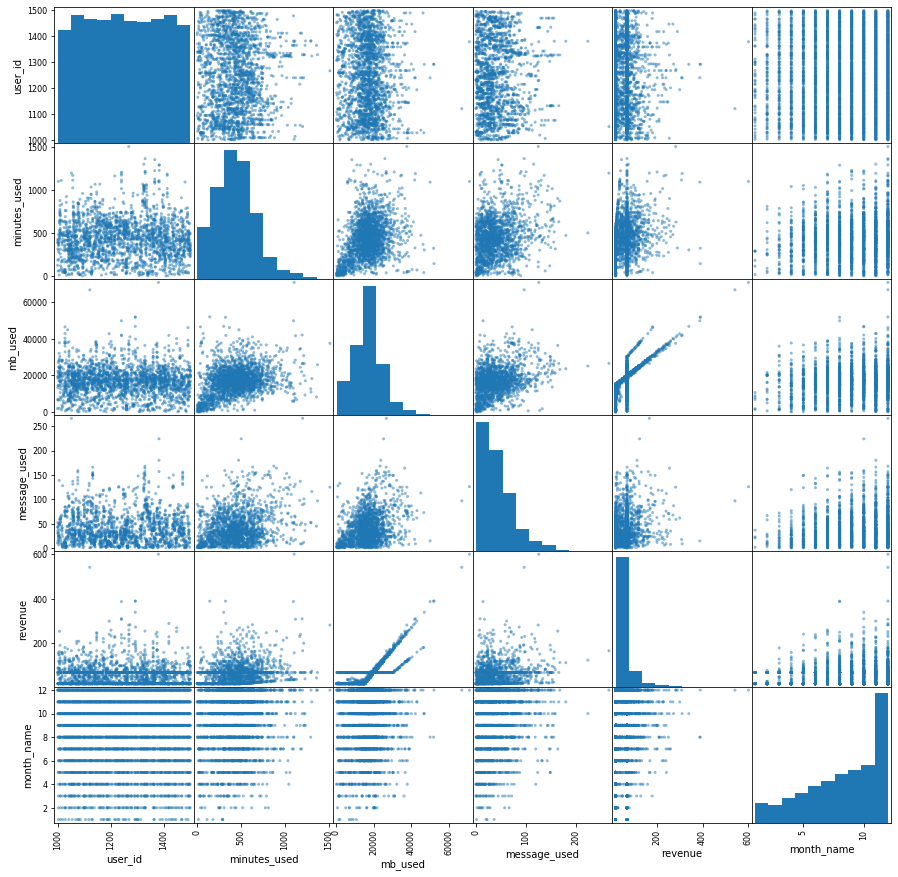

In [41]:
print(pd.plotting.scatter_matrix(report, figsize=(15,15)))

In [42]:
# index_vals = report['plan'].astype('category').cat.codes
# fig = go.Figure(data=go.Splom(
#                 dimensions=[dict(label='minutes_used',
#                                  values=report['minutes_used']),
#                             dict(label='mb_used',
#                                  values=report['mb_used']),
#                             dict(label='message_used',
#                                  values=report['message_used']),
#                             dict(label='revenue',
#                                  values=report['revenue'])],
#                 text=report['plan'],
#                 marker=dict(color=index_vals,
#                             showscale=False, # colors encode categorical variables
#                             line_color='white', line_width=0.5
#                            )
#                 ))


# fig.update_layout(
#     title='Correlation report for two mobile operator tariff plans',
#     dragmode='select',
#     width=900,
#     height=900,
#     hovermode='closest',
# )

# fig.show()

**Plans**
* yellow is <span style="color:yellow">*ultimate*</span> 
* blue is <span style="color:blue">*surf*</span> 

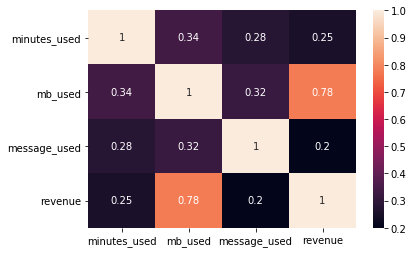

In [33]:
data = {'A': [45,37,42,35,39],
        'B': [38,31,26,28,33],
        'C': [10,15,17,21,12]
        }

df = pd.DataFrame(report,columns=['minutes_used', 'mb_used',
       'message_used', 'revenue'])

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Preliminary analysis reveals that the greatest correlation is observed between revenue and traffic. Excess of message limits and calls - slightly. The resulting distributions require a more detailed analysis.

# histograms of users behavior

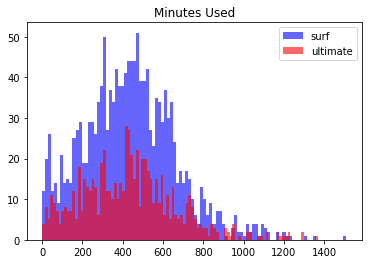

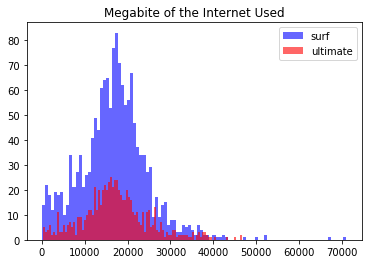

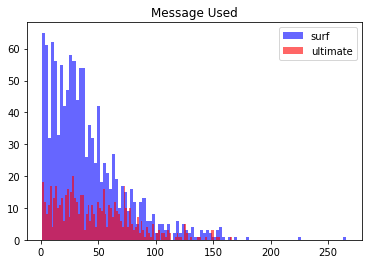

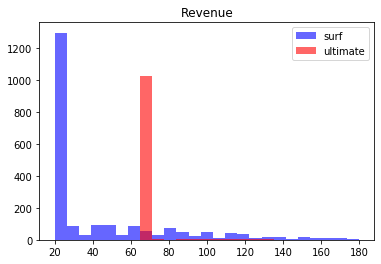

In [34]:
# report[report['plan']=='surf'].hist()
# report[report['plan']=='ultimate'].hist()

pyplot.hist(report[report['plan']=='surf']['minutes_used'], bins=100, alpha=.6, label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['minutes_used'], bins=100, alpha=.6, label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Minutes Used', fontdict=None, loc='center', pad=None)
pyplot.show()

pyplot.hist(report[report['plan']=='surf']['mb_used'], bins=100, alpha=.6, label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['mb_used'], bins=100, alpha=.6, label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Megabite of the Internet Used', fontdict=None, loc='center', pad=None)
pyplot.show()

pyplot.hist(report[report['plan']=='surf']['message_used'], bins=100, alpha=.6, label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['message_used'], bins=100, alpha=.6, label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Message Used', fontdict=None, loc='center', pad=None)
pyplot.show()

pyplot.hist(report[report['plan']=='surf']['revenue'], bins=25, alpha=.6, range=(20,180), label='surf', color='blue')
pyplot.hist(report[report['plan']=='ultimate']['revenue'], bins=25, alpha=.6, range=(20,180), label='ultimate', color='red')
pyplot.legend(loc='upper right')
pyplot.title(label='Revenue', fontdict=None, loc='center', pad=None)
pyplot.show()

In [35]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


You can see that regardless of the tariff, users behave the same in terms of consumption limits. Also we can say that messages is not popular.

# Stat Report table

In [36]:
stat_report = (report
    .pivot_table(
        index=['plan','month'], 
        values=['minutes_used','mb_used','message_used'], 
        aggfunc=['var','std','mean'])
    .reset_index()
)

stat_report

plan      month           var                             \
                              mb_used message_used  minutes_used   
0       surf 2018-01-01  1.827706e+07          NaN  15842.000000   
1       surf 2018-02-01  4.377810e+07   512.800000  52226.500000   
2       surf 2018-03-01  6.839062e+07   352.062500  35809.363636   
3       surf 2018-04-01  5.734854e+07   534.028571  50866.743265   
4       surf 2018-05-01  5.979663e+07   867.945130  56938.779459   
5       surf 2018-06-01  4.518662e+07   936.406393  44094.061404   
6       surf 2018-07-01  6.296625e+07   907.985836  59802.012325   
7       surf 2018-08-01  7.073670e+07  1013.315762  52122.749224   
8       surf 2018-09-01  5.023945e+07   943.051126  44579.912538   
9       surf 2018-10-01  5.993660e+07  1249.551526  49792.856075   
10      surf 2018-11-01  5.583757e+07  1020.738294  49626.013493   
11      surf 2018-12-01  7.054659e+07  1380.905552  60530.283374   
12  ultimate 2018-01-01  1.642061e+07   310.333333  16572.333333   
13  ultimate 2018-02-01  3.774840e+07   465.366667  54345.066667   
14  ultimate 2018-03-01  1.406093e+08   613.904762  61984.931818   
15  ultimate 2018-04-01  8.859513e+07   512.862500  34888.928571   
16  ultimate 2018-05-01  5.689892e+07  1246.933333  43841.046798   
17  ultimate 2018-06-01  7.214565e+07   807.238265  37902.570707   
18  ultimate 2018-07-01  6.855162e+07   858.084181  72563.374635   
19  ultimate 2018-08-01  6.142269e+07  1033.126948  53298.630228   
20  ultimate 2018-09-01  4.906982e+07   902.878943  58048.397017   
21  ultimate 2018-10-01  5.515029e+07  1111.262278  53276.230676   
22  ultimate 2018-11-01  5.842497e+07  1093.480594  60538.293882   
23  ultimate 2018-12-01  6.305502e+07  1384.813440  60004.264957   

             std                                    mean               \
         mb_used message_used minutes_used       mb_used message_used   
0    4275.167599          NaN   125.865007   4881.000000    21.000000   
1    6616.502257    22.645088   228.531179  12192.888889    21.600000   
2    8269.861896    18.763329   189.233622  13361.043478    21.937500   
3    7572.882161    23.109058   225.536567  12243.061224    24.166667   
4    7732.828271    29.460909   238.618481  14136.842105    33.017857   
5    6722.099200    30.600758   209.985860  15642.084211    33.616438   
6    7935.127683    30.132803   244.544500  16943.208333    35.945055   
7    8410.511477    31.832621   228.304072  17132.125786    37.596774   
8    7087.979447    30.709137   211.139557  16696.979275    39.523179   
9    7741.873470    35.348996   223.143129  17565.821739    42.193548   
10   7472.453911    31.948995   222.768969  16514.167883    40.877273   
11   8399.201994    37.160538   246.029030  18262.798680    48.221311   
12   4052.235052    17.616280   128.733575   6926.250000    20.666667   
13   6143.972858    21.572359   233.120284  17148.857143    25.166667   
14  11857.880971    24.777102   248.967732  18340.250000    34.714286   
15   9412.498689    22.646468   186.785783  16140.476190    28.937500   
16   7543.137575    35.311943   209.382537  16643.758621    44.333333   
17   8493.859703    28.411939   194.685826  15355.106383    36.289474   
18   8279.590645    29.293074   269.375898  16363.677966    41.212766   
19   7837.263156    32.142292   230.864961  17829.700000    48.517857   
20   7004.985184    30.047944   240.932349  17175.428571    46.724638   
21   7426.324154    33.335601   230.816444  17808.711538    47.045455   
22   7643.623106    33.067818   246.045309  17149.088710    48.138614   
23   7940.719204    37.213082   244.957680  18327.000000    54.524590   

                 
   minutes_used  
0    203.000000  
1    297.000000  
2    330.000000  
3    351.540000  
4    410.240000  
5    435.791667  
6    453.733333  
7    417.849057  
8    420.732984  
9    438.171053  
10   434.037037  
11   486.868687  
12   193.500000  
13   470.333333  
14   304.250000  
15   336.857143  
16   406.241379 

Text(0.5, 1.0, 'Revenue')

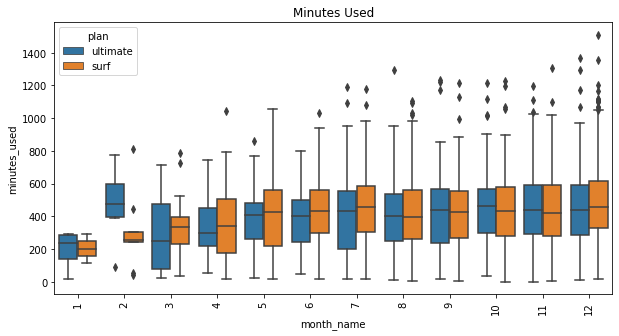

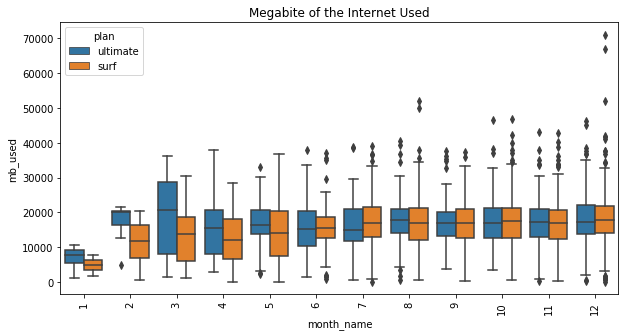

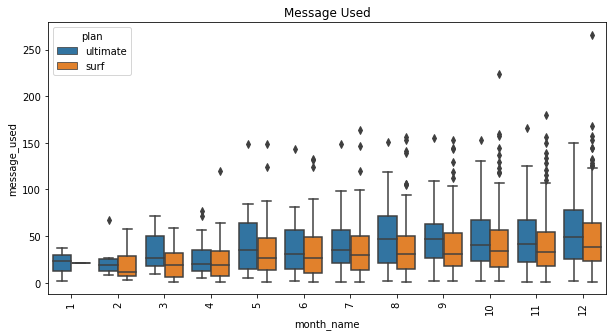

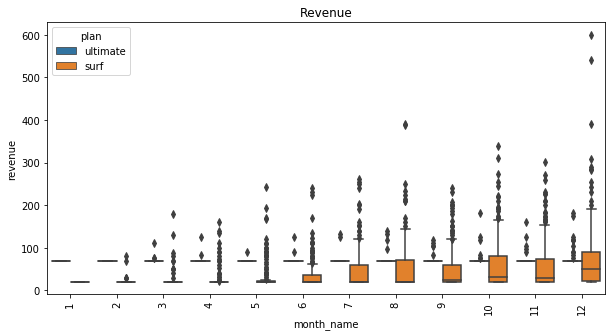

In [37]:
report['month_name'] = pd.to_datetime(report['month'], format='%m').dt.month

plt.figure(figsize=(10,5))
sns.boxplot(y='minutes_used', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Minutes Used')

plt.figure(figsize=(10,5))
sns.boxplot(y='mb_used', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Megabite of the Internet Used')

plt.figure(figsize=(10,5))
sns.boxplot(y='message_used', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Message Used')

plt.figure(figsize=(10,5))
sns.boxplot(y='revenue', x='month_name', 
                 data=report, 
                 #palette="colorblind",
                #dodge=True,
                 hue='plan')
plt.xticks(rotation=90)
plt.title('Revenue')

As can be seen from the measures taken of the central tendency and dispersion, from month to month users do not change their behavior regardless of the plan. It is worth noting that the first three months in the data differ from the subsequent ones, since there were fewer users in the sample. On the other hand, we see how the average profit of tariff plan "surf" is growing from month to month, gradually catching up with the average frozen tariff "ultimate" plan.

# 1. Hypothesis: 
## the average profit from users of Ultimate and Surf calling plans differs

This is bilateral hypothes. In other words, we will not know more or less one tariff in relation to another. We will find out if the average profit differs in tariffs in general. Besides profit, it was also interesting to see if the average use of limits is different.

In [38]:
surf = report[report['plan'] == 'surf']
surf['minutes_used'] = surf['minutes_used'].fillna(value=0)
surf['mb_used'] = surf['mb_used'].fillna(value=0)
surf['message_used'] = surf['message_used'].fillna(value=0)
surf = surf.dropna()

ultimate = report[report['plan'] == 'ultimate']
ultimate['minutes_used'] = ultimate['minutes_used'].fillna(value=0)
ultimate['mb_used'] = ultimate['mb_used'].fillna(value=0)
ultimate['message_used'] = ultimate['message_used'].fillna(value=0)
ultimate = ultimate.dropna()

#First hypothesis
print("Null hypothesis - minutes mean of two plas are equal")
results_minutes = st.ttest_ind(
        surf['minutes_used'], 
        ultimate['minutes_used'])
print('p-value: ', results_minutes.pvalue.round(4))
if (results_minutes.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")
print()

#Second
print("Null hypothesis - mb mean of two plas are equal")
results_mb = st.ttest_ind(
        surf['mb_used'], 
        ultimate['mb_used'])
print('p-value: ', results_mb.pvalue.round(4))
if (results_mb.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")
print()

#Fird
print("Null hypothesis - sms mean of two plas are equal")
results_message = st.ttest_ind(
        surf['message_used'], 
        ultimate['message_used'])
print('p-value: ', results_message.pvalue.round(4))
if (results_message.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")
print()

#Forth
print("Null hypothesis - revenue mean of two plas are equal")
results_revenue = st.ttest_ind(
        surf['revenue'], 
        ultimate['revenue'])
print('p-value: ', results_revenue.pvalue.round(50))
if (results_revenue.pvalue < 0.05):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

Null hypothesis - minutes mean of two plas are equal
p-value:  0.2598
We can't reject the null hypothesis

Null hypothesis - mb mean of two plas are equal
p-value:  0.9244
We can't reject the null hypothesis

Null hypothesis - sms mean of two plas are equal
p-value:  0.0033
We reject the null hypothesis

Null hypothesis - revenue mean of two plas are equal
p-value:  3.1339999999999997e-47
We reject the null hypothesis


I used a significance level of 0.05. The test shows that the average for calls and traffic do not differ significantly from each other in two groups. But according to the average sent messages - they differ. This seems strange, because visually distributions overlap each other. This can be explained by the fact that the distribution is abnormal. The difference in income averages of the two groups is significant.

# 2. Hypothesis: 
## the average profit from users in NY-NJ area is different from that of the users from other regions.

In [39]:
report_city_ny_nj = report[report['city'].str.contains('NY-NJ')]
report_other_cities = report[~report['city'].str.contains('NY-NJ')]

print("Null hypothesis - revenue mean of two places are equal")
results_revenue = st.ttest_ind(
        report_city_ny_nj['revenue'], 
        report_other_cities['revenue'])
print('p-value: ', results_revenue.pvalue.round(10))

Null hypothesis - revenue mean of two places are equal
p-value:  0.0508099639


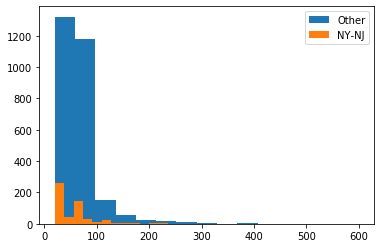

In [40]:
# plt.hist(report_city_ny_nj['revenue'])
# plt.hist(report_another_cities['revenue'])
# plt.show()

pyplot.hist(report_other_cities['revenue'], bins=15, alpha=1, label='Other')
pyplot.hist(report_city_ny_nj['revenue'], bins=15, alpha=1, label='NY-NJ')
pyplot.legend(loc='upper right')
pyplot.show()

Student's test showed that the average profit for the regional sample NY-NJ showed a difference from all other regions. But this difference is on the verge of a criterion of significance .05. More stringent .01 criteria will drop the null hypothesis. Softer .1 will leave. The observed distribution is not normal. The group average should not be significantly different, as their variation will overlap their means. So I do not reject the null hypothesis.

# Summary

I have conducted an analysis of a sample of clients of a mobile operator’s network. 

Preliminary analysis showed that:
- Users of the "surf" plan are twice as many 
- Users "surf" brougth 42% more profit then users on utimate plan
- "ultimate" plan brought 23 dollars more profit per user
Correlation test showed that:
- The greatest contribution to profit is made by payments for the overspending of Internet traffic.

Further research indicated that users in general, regardless of the tariff plan, use the same amount of traffic. 
Student's test partly confirms the identity of the behavior of two groups of users. 
A comparison of the average traffic usage and calls indicates that their differences are within the statistical error. 
For users of a more expensive tariff plan, the limit is higher, so they overpay less. 
In other words, lowering the tariff bar should not affect user behavior. 
Further, it was revealed how, from month to month, tariff plan "surf" overtook the frozen plan "ultimate". 
Profits from tariff plan "surf" became more and more. 

**Recommendations**

Based on the data obtained, to get more income you need, it is necessary to attract more users to a "cheaper" tariff. Or expand the number of tariff plans within the normal distribution of the use of Internet traffic.